In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.stats as sps
from tqdm import tqdm
rng = np.random.default_rng()

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from graph import RandomGraph

## Исследование динамики системы для $H_i \sim \mathcal{N}(0, \Sigma)$ (многомерный случай)

В этой части задачи предпочтения агентов скоррелированы: $H_i \sim \mathcal{N}(\vec 0, \Sigma)$, где $\Sigma$ — некоторая недиагональная матрица ковариаций. Логично предположить, что в таком случае агенты окажутся более связанными, зависимыми друг от друга, в связи с чем переходы между крайними состояниями станут более резкими, а разница траекторий — более выраженной. Посмотрим, так ли это. 

Для начала сгенерируем матрицу ковариаций — она должна быть симметричной и неотрицательно определённой. Делать это будем по следующей схеме:
1. Сгенерируем $N$ независимых одинаково распределённых случайных величин $\eta_i \sim \mathcal{N}(0, 1)$.
2. Выберем $\beta \in (0, 1]$. Назовём это число степенью корреляции. 
3. Сформируем $N$ зависимых случайных величин $H_i$, по одной для каждой вершины. Для этого построим дерево обхода в ширину: пусть $V_0$ — множество вершин нулевого уровня, $V_1$ — 1-го уровня, $\dots V_m$ — $m$-го уровня. Выберем для всех вершин $0$-го уровня $H_i$ = $\eta_i$. Для остальных же поступим так: пусть $u$ — предок вершины $v$ в дереве обхода в ширину, тогда
$$
    H_v = \beta H_u + \sqrt{1 - \beta^2} \cdot \eta_v.
$$
4. Заметим, что $H_i$, во-первых, образуют гауссовский вектор, т.к. являются линейными комбинациями независимых нормально распределённых случайных величин, во-вторых, обладают нулевым средним и единичной дисперсией (т.к. $\mathop{D} \eta_i = 1 \: \forall \: i$, $\eta_i$ независимы, а квадраты коэффициентов суммируются в единицу), и в третьих, $H_i$ для соседних в дереве обхода вершин оказываются скоррелированы, причём величину этой корреляции можно варьировать, меняя параметр $\beta$.

Минус такой схемы, конечно, в том, что мы никак не учитываем циклы: вершины могут быть связаны ребром и в то же время находиться далеко друг от друга в дереве обхода, тогда они окажутся слабо скоррелированы, хотя, казалось бы, должно быть наоборот, ведь они соседние. Однако для наблюдения общей картины того, что происходит при изменении "скоррелированности" отдельных полей, такого приближения должно быть достаточно.

In [4]:
import sys

sys.setrecursionlimit(10 ** 5)

In [5]:
N = 10000
l = 4
J = 0.5
alpha = 2.185
G_Poisson = RandomGraph(N, sps.poisson(l))
G_zipf = RandomGraph(N, sps.zipf(alpha))

In [14]:
beta_grid = np.array([0.925, 0.95, 0.97, 0.98, 0.99, 1.0])
H_max = 4
H_grid = np.linspace(-H_max, H_max, 300)

Точно так же, как в первой части, будем плавно изменять $H$, сначала повышая его, а потом понижая.

6it [29:19, 293.18s/it]


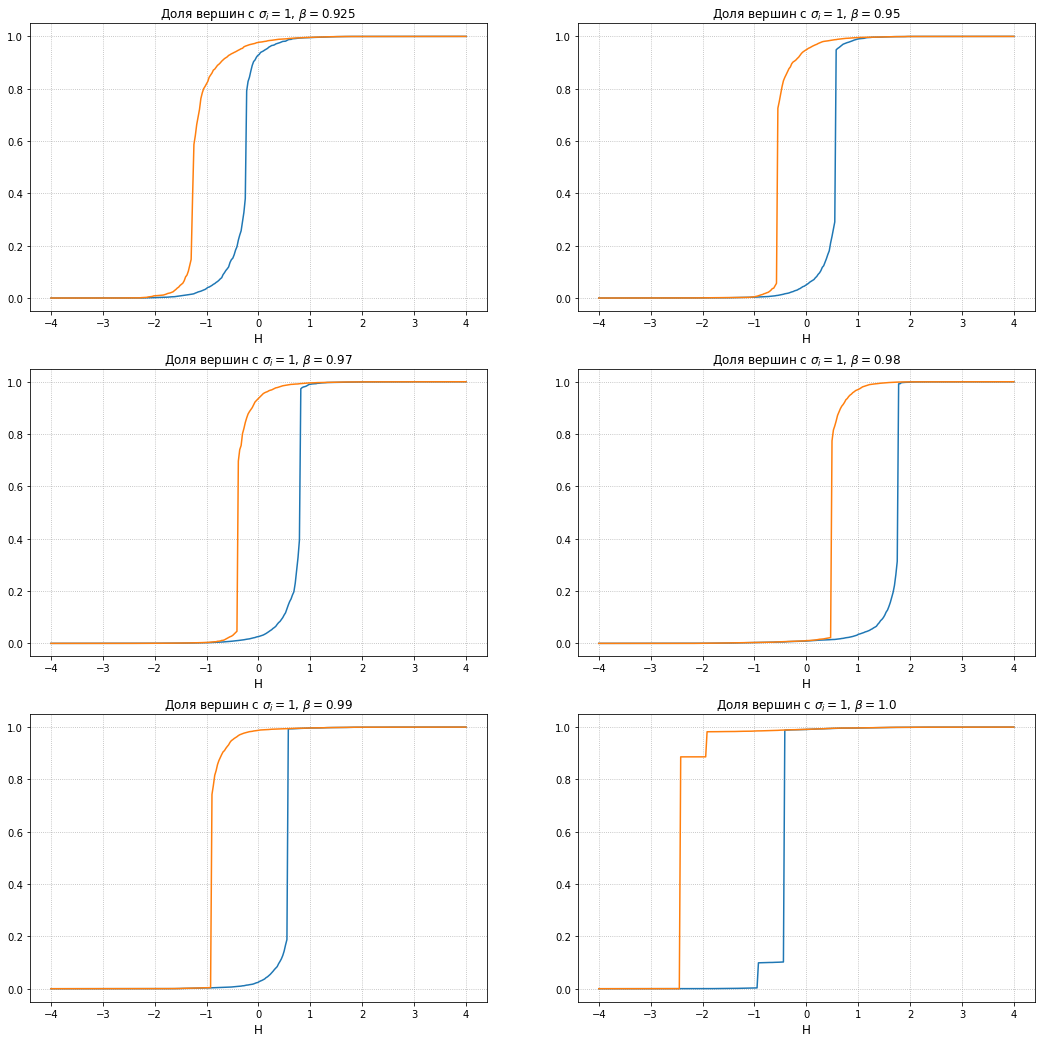

In [16]:
plt.figure(figsize=(18, 18))
for index, beta in tqdm(enumerate(beta_grid)):
    low_to_high, high_to_low = G_Poisson.get_trajectories(J, H_grid, beta, 'multivariate_norm')
    
    plt.subplot(3, 2, index + 1)
    plt.plot(H_grid, low_to_high, label='при повышении H')
    plt.plot(np.flip(H_grid), high_to_low, label='при снижении H')
    plt.grid(ls=':')
    plt.xlabel('H', fontsize='large')
    plt.title(r'Доля вершин с $\sigma_i = 1$, $\beta = {0}$'.format(round(beta, 3)))

При увеличении $\beta$ графики становятся более резкими, более выраженным становится последний лавинообразный переход, когда меняют своё состояние большая часть вершин (до $80 \%$ на последних двух графиках). До него также заметен более резкий рост, чем при малых корреляциях. Хочется, кроме того, отметить, что ситуация начинает заметно меняться лишь при очень высоких значениях $\beta$, порядка $\sim0{,}95$ — до них изменения не заметны.

In [21]:
beta_grid = np.array([0.92, 0.97, 0.99, 0.994, 0.997, 1.0])
H_max = 5
H_grid = np.linspace(-H_max, H_max, 300)

6it [27:33, 275.57s/it]


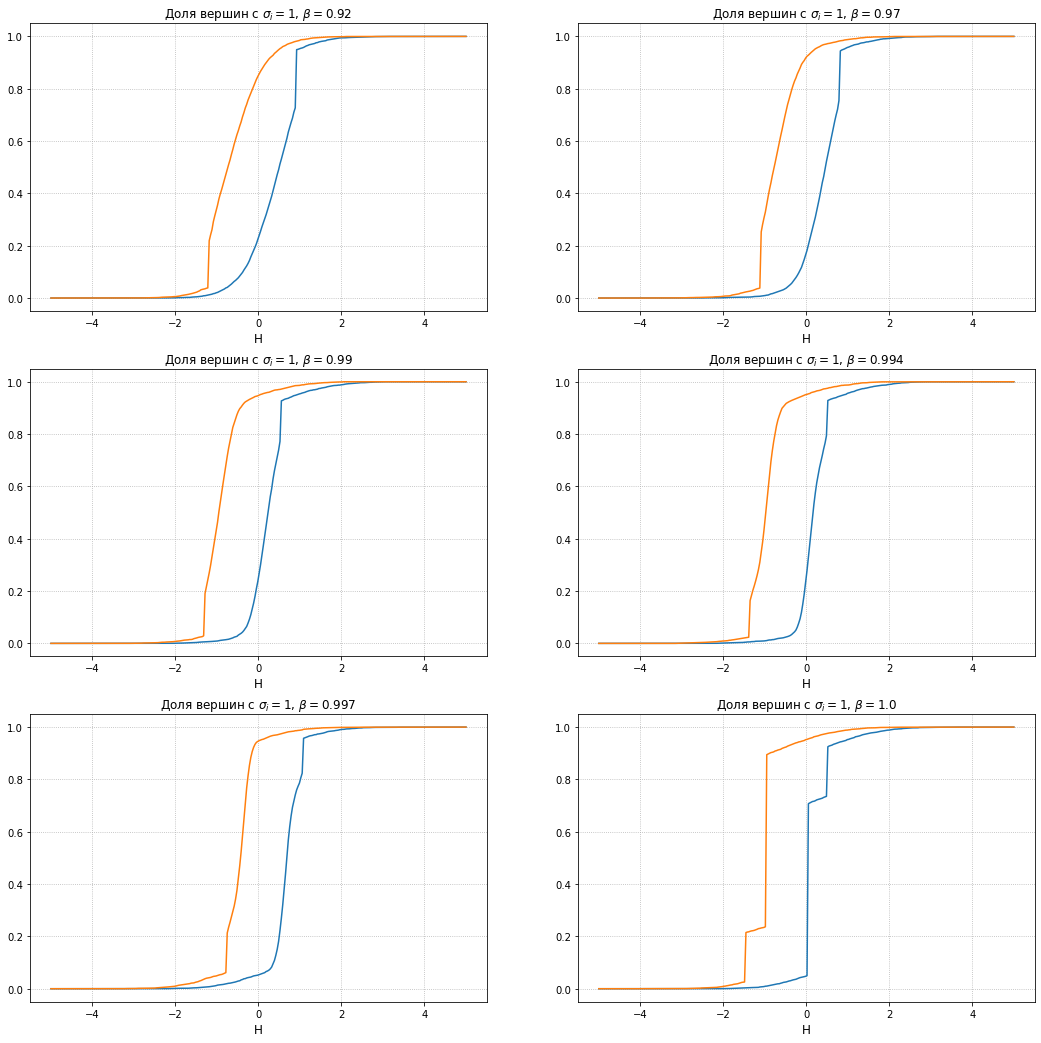

In [22]:
plt.figure(figsize=(18, 18))
J = 0.5
for index, beta in tqdm(enumerate(beta_grid)):
    G_zipf.sample_correlated(beta)
    low_to_high, high_to_low = G_zipf.get_trajectories(J, H_grid, beta, 'multivariate_norm')
    
    plt.subplot(3, 2, index + 1)
    plt.plot(H_grid, low_to_high, label='при повышении H')
    plt.plot(np.flip(H_grid), high_to_low, label='при снижении H')
    plt.grid(ls=':')
    plt.xlabel('H', fontsize='large')
    plt.title(r'Доля вершин с $\sigma_i = 1$, $\beta = {0}$'.format(round(beta, 3)))

Для степенного графа отличие от одномерного случая заметно: на графиках в конце процесса появляется "ступенька" — после лавины с переворачиванием хабов система всё ещё не переходит в состояние, в котором прямая и обратная траектории совпадают, определённая разница сохраняется ещё некоторое время, из-за чего область между траектории оказывается зигзагообразной.

Также отмечу, что какие-то заметные эффекты начинаются лишь при очень больших корреляциях, ещё больше, чем в случае пуассоновского графа ($\beta \approx 0{,}995$). Почему-то даже, казалось бы, сильная "связанность" вершин и малая разница между соседними $H_i$ не приводят к заметному эффекту. Возможно, это связано с отбрасыванием циклов при генерации $H_i$, которое всё-таки оказывается критичным.